# Imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

from Modules import TransformerAutoencoder
from Modules import LinearAutoencoder
from Modules import RandomConnexionsTransformerAutoencoder

/home/antoine/anaconda3/envs/Emergence/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Device

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(f"Using {device} device")

Using cuda device


# Dataset

In [3]:
# We are only interested to train autoencoders, so we flatten the 2dim of the images and
# squeeze the single channel dimension
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: torch.squeeze(x)),
    transforms.Lambda(lambda x: torch.flatten(x, start_dim=-2))])

train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

# Train and test data tensors loaded on the GPU
# train_data = train_dataset.data.clone().detach().type(torch.float16).flatten(start_dim=-2).to(device)
# test_data = test_dataset.data.clone().detach().type(torch.float16).flatten(start_dim=-2).to(device)
# TODO pourquoi entre float16 et float32 ya pas un facteur 2 de taille de mémoire, et pareil pour float32 à float64 ?

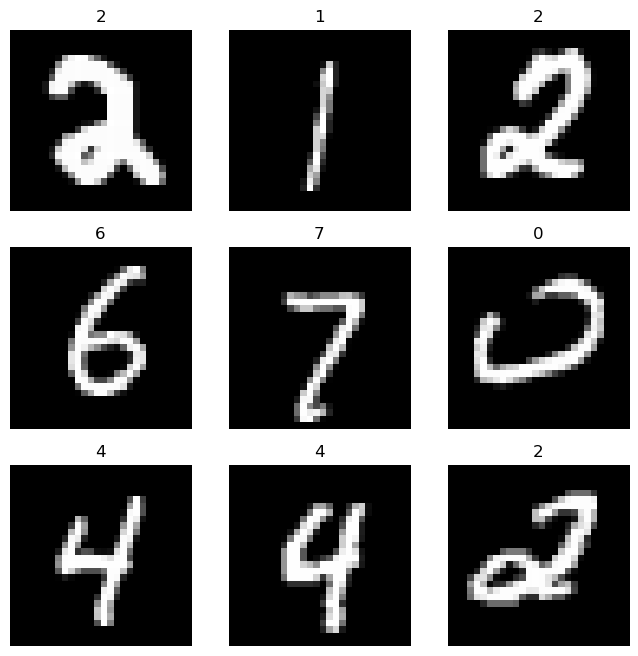

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.reshape((28, 28)), cmap="gray")
plt.show()

In [5]:
batch_size = 32

# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

for X, _ in train_dataloader:
    print(f"Shape of X: {X.shape}")
    break

Shape of X: torch.Size([32, 784])


# Autoencoder

In [6]:
# transformer_autoencoder = TransformerAutoencoder(dim_sequence=28*28, dim_bottleneck=2, dim_positional_encoding=2, num_heads=2, num_layers=2).to(device)
# linear_autoencoder = LinearAutoencoder(dim_input=28*28, dim_bottleneck=2, step= 3, activation_function='ReLU').to(device) # TODO faire que dim_input soit automatique du dataset
random_connexions_transformer_autoencoder = RandomConnexionsTransformerAutoencoder(
    dim_input=28*28,
    dim_embedding=28,
    dim_bottleneck=2,
    num_heads=12,
    dim_positional_encoding=2,
    num_layers=12
).to(device)

model = random_connexions_transformer_autoencoder
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(random_connexions_transformer_autoencoder.parameters(), lr=1e-3)
# TODO tellement de trucs à fine-tuner ici...

# Train

In [7]:
def train_autoencoder(dataloader: DataLoader, model, loss_function, optimizer):
    """Right now, when iterated over, the dataloader returns a data point AND a label. 
    TODO faire en sorte que le dataloader soit composé que des images, sans les labels."""

    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_function(pred, X)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_autoencoder(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            pred = model(X)
            test_loss += loss_function(pred, X).item()
    test_loss /= num_batches
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")
    

## Train loop

In [8]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_autoencoder(train_dataloader, model, loss_function, optimizer)
    test_autoencoder(test_dataloader, model, loss_function)
print("Done!")

Epoch 1
-------------------------------
loss: 0.486450  [    0/60000]
loss: 0.079320  [ 3200/60000]
loss: 0.091661  [ 6400/60000]
loss: 0.077289  [ 9600/60000]
loss: 0.070107  [12800/60000]
loss: 0.079165  [16000/60000]


KeyboardInterrupt: 

# Print result

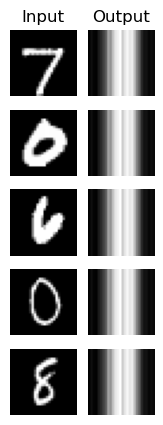

In [9]:
n = 5
fig, axs = plt.subplots(n, 2, figsize=(2,5))
for i in range(n):
    # Input
    random_index = np.random.randint(len(test_dataset))
    img, label = test_dataset[random_index]
    ax = axs[i, 0]
    ax.imshow(img.reshape((28, 28)), cmap='gray')
    ax.axis("off")
    if i == 0: ax.set_title('Input')

    # Output
    input_image = img.to(device)
    model.eval()
    with torch.no_grad():
        output_image = model(input_image)

    ax = axs[i, 1]
    ax.imshow(output_image.cpu().detach().numpy().reshape((28, 28)), cmap="gray")
    ax.axis("off")
    if i == 0: ax.set_title('Output')
plt.subplots_adjust(wspace=0.0)
plt.show()

In [ ]:
# TODO faire un environnement "try" ou quand on quitte l'environnement on enregistre le modèle dans l'état actuel, la training curve, etc
# vérifier que si Windows décide d'update il quitte python de façon clean et lui laisse le temps d'enregistrer et tout